In [1]:
import numpy as np
import pandas as pd
from scipy.special import logit, expit
from scipy.stats import bernoulli
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics
from downcast import downcast_df

In [2]:
def plot_sample_sim(glm):
    # Prior
    # Plotting distribution of scores simulated from prior
    prior_samples = glm["prior_sim"].prior_predictive.sel(chain=0)
    postrr_samples = glm["postrr_sim"].posterior_predictive.sel(chain=0)
    target = "s"

    # Manipulating samples to plot
    df_prior, na_s = downcast_df(prior_samples[target].to_dataframe().reset_index())
    df_postrr, na_s = downcast_df(postrr_samples[target].to_dataframe().reset_index())

    # Joining rater/topic/model/corpus information
    data1 = data.copy()
    data1[f"{target}_dim_0"] = data1.index
    df_prior1 = pd.merge(df_prior, data1, on=target+"_dim_0", how="left")
    df_postrr1 = pd.merge(df_postrr, data1, on=target+"_dim_0", how="left")

    # Aggregating "1s" and counts by topic
    prior_agg = df_prior1.groupby(["draw", "topic_id"]).agg({target:["sum", "count"]}).reset_index()
    postrr_agg = df_postrr1.groupby(["draw", "topic_id"]).agg({target:["sum", "count"]}).reset_index()
    obs_agg = df_prior1[df_prior1["chain"]==0].groupby(["draw", "topic_id"]).agg({"intrusion":["sum", "count"]}).reset_index()

    # Calculating topic probabilities from sums and counts
    prior_topic_prob = prior_agg[("s","sum")]/prior_agg[("s","count")]
    postrr_topic_prob = postrr_agg[("s","sum")]/postrr_agg[("s","count")]
    obs_topic_prob = obs_agg[("intrusion","sum")]/obs_agg[("intrusion","count")]

    # Setting up plot
    plot, ax = plt.subplots(1, 1,figsize=(10,6))
    ax = az.plot_kde(np.array(prior_topic_prob), bw=0.05)
    ax.get_lines()[0].set_color("orange")
    ax.get_lines()[0].set_linestyle("--")
    ax = az.plot_kde(np.array(postrr_topic_prob), bw=0.05)
    ax.get_lines()[1].set_color("green")
    ax.get_lines()[1].set_linestyle("--")
    ax = az.plot_kde(np.array(obs_topic_prob), bw=0.05)
    ax.set_title("Prior dist: number of 1's per topic")
    ax.set_ylabel("Density")
    ax.set_xlabel("p")
    ax.legend(ax.get_lines(), ["Prior", "Posterior", "Observed"])

    plt.plot()

In [3]:
raw_data = pd.read_csv("data/unit_level_ratings.csv",index_col = 0)
raw_data = raw_data.sort_values(by=["corpus", "model", "topic"])

In [4]:
# Creating identifier for each corpus, model, and topic
# Identifier is unique for topic 
corpus_ids = (raw_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (raw_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (raw_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

topic_ids = (raw_data.groupby(["corpus", "model", "topic"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
topic_ids["topic_id"] = topic_ids.index 

rater_ids = (raw_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 


d1 = pd.merge(raw_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

In [5]:
# Setting up numpy arrays for pymc
corpus_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

model_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordel_array = np.array(data["cordel_id"])
n_cordels = data["cordel_id"].nunique()

topic_array = np.array(data["topic_id"])
n_topics = data["topic_id"].nunique()

rater_array = np.array(data["rater_id"])
n_raters = data["rater_id"].nunique()

score_array = np.array(data["intrusion"])

## Models

In [6]:
# Model and MCMC specifications

n_cores = 4
emprical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
cm_lambda = 2

In [7]:
# Collection of model, trace, prior & posterior simulations
# {"model": pm.Model, 
#  "trace": az.InferenceData, 
#  "prior_sim": az.InferenceData, 
#  "postrr_sim": az.InferenceData}

glm_mean = {"model":pm.Model()}
glm_cordel = {"model":pm.Model()}
glm_topic = {"model":pm.Model()}
glm_topic_cordel = {"model":pm.Model()} # cordel contains cross join of corpus and topic 
# glm_topic_corpora_model = {"model":pm.Model()}
glm_rater_topic = {"model":pm.Model()}
glm_rater_topic_cordel = {"model":pm.Model()}
# glm_rater_model_corpora = {"model":pm.Model()}

In [7]:
# Mean-only model

glm_mean["model"] = pm.Model()
with glm_mean["model"]:
    mu = pm.Normal("mu", mu=0, sigma=1.5)
    p = pm.math.invlogit(mu)
    s = pm.Bernoulli("s", p=p, observed=score_array)
    
    glm_mean["trace"]=pm.sample(cores=n_cores)

NameError: name 'score_array' is not defined

In [ ]:
# cordel-only model

glm_cordel["model"] = pm.Model()
with glm_cordel["model"]:
    sigma_c = pm.Exponential("sigma_c", lam=cm_lambda)
    zc = pm.Normal("zc",mu=emprical_mean, sigma=1, shape=n_cordels)
    p = pm.math.invlogit(zc[cordel_array]*sigma_c)
    s = pm.Bernoulli("s", p=p, observed=score_array)
    
    glm_cordel["trace"]=pm.sample(cores=n_cores)

In [ ]:
# Rater and cordel model

glm_rater_cordel["model"] = pm.Model()
with glm_rater_cordel["model"]:
    # Hyperparameter priors
    sigma_c = pm.Exponential("sigma_c", lam=cm_lambda)
    zc = pm.Normal("zc",mu=emprical_mean, sigma=1, shape=n_cordels)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=1, shape=n_topics)
    
    p = pm.math.invlogit(
        za[topic_array]*sigma_a+
        zc[cordel_array]*sigma_c)
    s = pm.Bernoulli("s", p=p, observed=score_array)

    glm_rater_cordel["trace"]=pm.sample(cores=n_cores)

In [ ]:
# Topic-only GLM

glm_topic["model"] = pm.Model()
with glm_topic["model"]:
    # Hyperparameter priors
    mu_a = pm.Normal("mu_a", mu=0, sigma=1.5)
    z = pm.Normal("z", mu=0, sigma=1, shape=n_topics)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda) 
    
    p = pm.math.invlogit(mu_a + z[topic_array]*sigma_a)
    
    # Likelihood is Bernoulli
    s = pm.Bernoulli("s", p=p, observed=score_array)

    glm_topic["trace"]=pm.sample(cores=n_cores)

In [ ]:
# Topic-rater GLMM

glm_rater_topic["model"] = pm.Model()
with glm_rater_topic["model"]:
    # Hyperparameter priors
    mu = pm.Normal("mu", mu=0, sigma=1.5)
    z_a = pm.Normal("z_a", mu=0, sigma=1, shape=n_topics)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda) 
    z_b = pm.Normal("z_b", mu=0, sigma=1, shape=n_raters)
    sigma_b = pm.Exponential("sigma_b", lam=r_lambda)
    
    p = pm.math.invlogit(mu + z_a[topic_array]*sigma_a + z_b[rater_array]*sigma_b)
    
    s = pm.Bernoulli("s", p=p, observed=score_array)

    glm_rater_topic["trace"]=pm.sample(cores=n_cores)

In [ ]:
# Topic and cordel model

glm_topic_cordel["model"] = pm.Model()
with glm_topic_cordel["model"]:
    # Hyperparameter priors
    sigma_c = pm.Exponential("sigma_c", lam=cm_lambda)
    zc = pm.Normal("zc",mu=emprical_mean, sigma=1, shape=n_cordels)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=1, shape=n_topics)
    
    p = pm.math.invlogit(za[topic_array]*sigma_a+zc[cordel_array]*sigma_c)
    s = pm.Bernoulli("s", p=p, observed=score_array)

    glm_topic_cordel["trace"]=pm.sample(cores=n_cores)

In [8]:
# Rater, Topic and cordel model

glm_rater_topic_cordel["model"] = pm.Model()
with glm_rater_topic_cordel["model"]:
    # Hyperparameter priors
    sigma_c = pm.Exponential("sigma_c", lam=cm_lambda)
    zc = pm.Normal("zc",mu=emprical_mean, sigma=1, shape=n_cordels)
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=1, shape=n_topics)
    
    p = pm.math.invlogit(
        za[topic_array]*sigma_a+
        zc[cordel_array]*sigma_c+
        zr[rater_array]*sigma_r)
    s = pm.Bernoulli("s", p=p, observed=score_array)

    glm_rater_topic_cordel["trace"]=pm.sample(cores=n_cores)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_c, zc, sigma_r, zr, sigma_a, za]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 256 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


## Diagnostics

In [12]:
glm = glm_rater_topic_cordel
glm

{'model': sigma_c ~ Exp(f())
      zc ~ N(1.1, 1)
 sigma_r ~ Exp(f())
      zr ~ N(0, 1)
 sigma_a ~ Exp(f())
      za ~ N(0, 1)
       s ~ Bern(f(sigma_r, zr, sigma_c, zc, sigma_a, za)),
 'trace': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data}

In [22]:
with glm["model"]:
    glm["prior_sim"]=pm.sample_prior_predictive(1_000)
    glm["postrr_sim"]=pm.sample_posterior_predictive(glm["trace"])

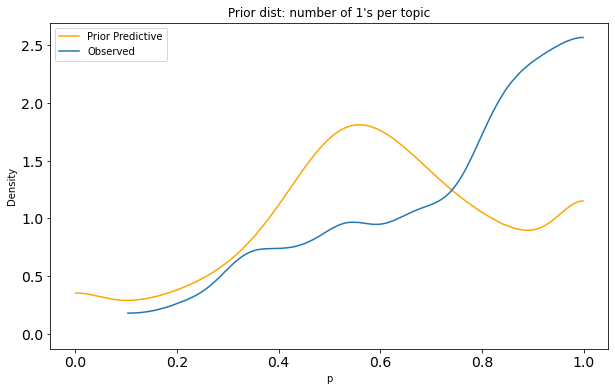

In [27]:
plot_sample_sim(glm)

In [13]:
summary_stat = az.summary(glm["trace"], round_to=4).reset_index()

# Creating parameter and parameter number columns
summary_stat["param"] = summary_stat["index"].str.split("[").str[0]
summary_stat["param_num"] = summary_stat["index"].str.split("[").str[1].str[:-1]
summary_stat["param"] = summary_stat["param"].astype("category")
summary_stat["param_num"] = summary_stat["param_num"].astype("category")
summary_stat = summary_stat[["param", "param_num"]+list(summary_stat.columns[1:-2])]

========================== trace diagnostics ==========================
Divergent transitions
0    24
1     5
2     8
3    16
dtype: int64


Variable with highest rhat
['zc', 0, 1.0095]


Variable with lowest effective sample size
['zc', 4, 601.9034]


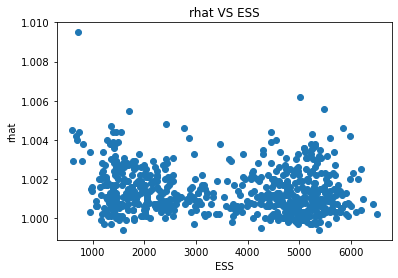

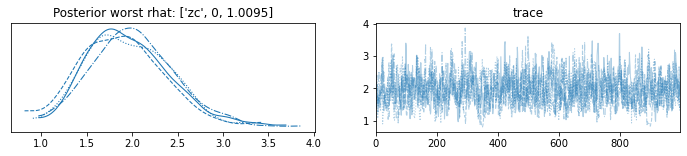

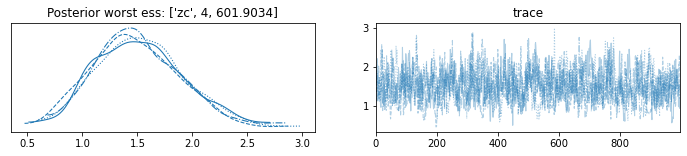

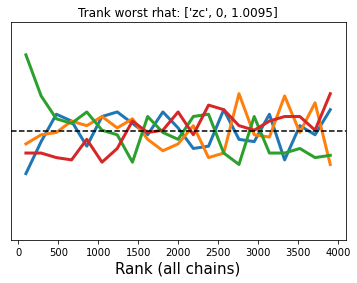

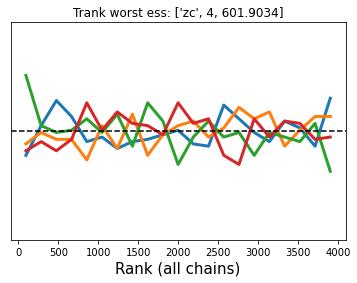

In [20]:
mcmc_diagnostics2(glm["trace"], summary_stat)

In [ ]:
summary_stat[(summary_stat["param"]!="za") & (summary_stat["param"]!="zr")]

In [ ]:
param="za"
ax=az.plot_kde(np.array(summary_stat["mean"][summary_stat["param"]==param]))
ax.set_title(f"Distribution of param {param}")
ax.set_xlabel("Parameter values")
ax.set_ylabel("Density")
plt.show()

In [ ]:
param="zr"
ax=az.plot_kde(np.array(summary_stat["mean"][summary_stat["param"]==param]))
ax.set_title(f"Distribution of param {param}")
ax.set_xlabel("Parameter values")
ax.set_ylabel("Density")
plt.show()

In [ ]:
# Plot distribution of topic location params
left = summary_stat[summary_stat["param"]=="za"]
left.loc[:,"param_num"]=left["param_num"].astype(int)
test = pd.merge(left, topic_ids, left_on="param_num", right_on="topic_id", how="left")

corpora = {"nytimes":"-", "wikitext":"--"}
models = {"dvae":"blue", "etm":"orange", "mallet":"green"}

fig, axs = plt.subplots(2, 1, figsize=(10,10))

for i, corpus in enumerate(corpora):
    for model in models:
        az.plot_kde(np.array(test[(test["corpus"]==corpus) & (test["model"]==model)]["mean"]), ax=axs[i])
        axs[i].get_lines()[-1].set_linestyle(corpora[corpus])
        axs[i].get_lines()[-1].set_color(models[model])
    axs[i].set_title(corpus)
    axs[i].legend(axs[i].get_lines(), models.keys())

In [ ]:
# Plot trace of parameter
param = "sigma_a"
param_num = None

# Trace
if param_num is None: 
    ax1 = az.plot_trace(glm["trace"].posterior[param], kind="trace")
else:
    ax1 = az.plot_trace(glm["trace"].posterior[param].sel(**{param+"_dim_0":param_num}), kind="trace")
ax1[0][0].set_title(f"Posterior {param}")
ax1[0][1].set_title("Trace")

# Trank
if param_num is None: 
    ax2 = az.plot_rank(glm["trace"].posterior[param],kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
else:
    ax2 = az.plot_rank(glm["trace"].posterior[param].sel(**{param+"_dim_0":param_num}),kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
ax2.set_title(f"Trank {param}")

plt.show()

## Model comparison

In [5]:
models = ["glm_mean", "glm_topic", "glm_topic_cordel", "glm_rater_topic", "glm_rater_topic_cordel"]
comparison = az.compare({m:eval(m)["trace"] for m in models})

NameError: name 'glm_mean' is not defined

In [ ]:
comparison.to_csv("model_comparison.csv")

In [ ]:
az.plot_compare(comparison.drop(index="glm_mean"))
plt.show()